In [1]:
import src.utils_energy_distribution as en_util
import src.utils_display as disp_util
import src.utils_optimization as opt_util
from src.focus_lens_quadric_primitive import FocusLensQuadricPrimitive
from src.focus_doe_quadric_primitive import FocusDOEQuadricPrimitive
from src.nn_modules import *

# torch.autograd.set_detect_anomaly(True)

device = "cpu"
print(f"Using {device} device")

Using cpu device


In [2]:
inds = np.indices((2, 3))
print(inds[0])
print(inds[1])

[[0 0 0]
 [1 1 1]]
[[0 1 2]
 [0 1 2]]


In [51]:
load_surface_file_name = 'data/8x8_300_surf.ebv'
load_project_file_name = 'data/2k8x8_proj.ebv'
load_NN_file_name = 'data/tmp_NN.ebv'

In [52]:
quadric_surface = FocusLensQuadricPrimitive.load(load_surface_file_name)
# quadric_surface = FocusDOEQuadricPrimitive.load(load_surface_file_name)

with open(load_project_file_name, 'rb') as file:
    project = pickle.load(file)

    quadrics = project['quadrics']
    quad_distrs = project['req_distrs']
    rays = project['rays']
    design_params = project['params']

model = OlikerUNet.load(load_NN_file_name)
model.cpu()
model.eval()

np_dtype = quadrics.dtype
torch_dtype = torch.float32 if np_dtype == np.single else torch.double

In [53]:
num_samples = int(2e2)
exit_x_num = 8
np_max = int(0.8 * exit_x_num ** 2)
np_min = int(0.2 * exit_x_num ** 2)

req_distrs = en_util.random_distribution(exit_x_num, np_min, np_max, total_flux=design_params['total_flux'],
                                         batch_size=num_samples, dtype=np_dtype)

In [54]:
data_x = opt_util.adapt_batch(req_distrs, device)
data_y = model.scaled_eval(data_x)
predicted_quadrics = opt_util.rev_adapt_batch(data_y)

In [55]:
tracing_results, _ = quadric_surface.trace_rays_batch(predicted_quadrics, rays)
rrmse = en_util.masked_rrmse_loss_batch(req_distrs, tracing_results)
print(f"Illum RRMSE= {rrmse.mean() :.4f}%.")

Illum RRMSE= 25.1747%.


Index=104


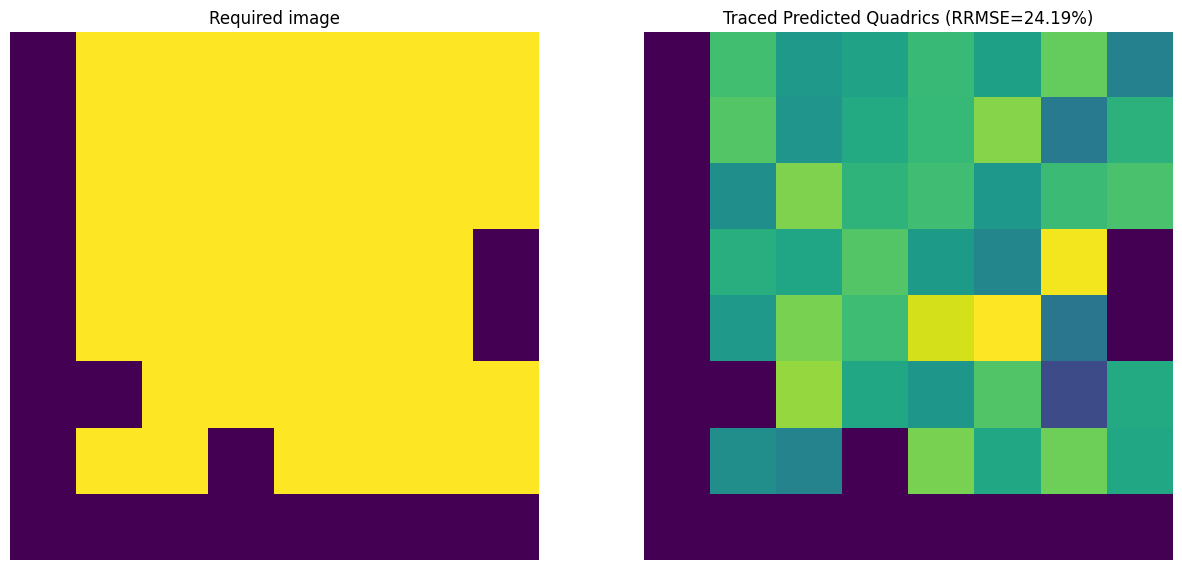

In [56]:
ind = disp_util.display_random_pairs([req_distrs], [tracing_results],
                                     titles=['Required image', 'Traced Predicted Quadrics'])

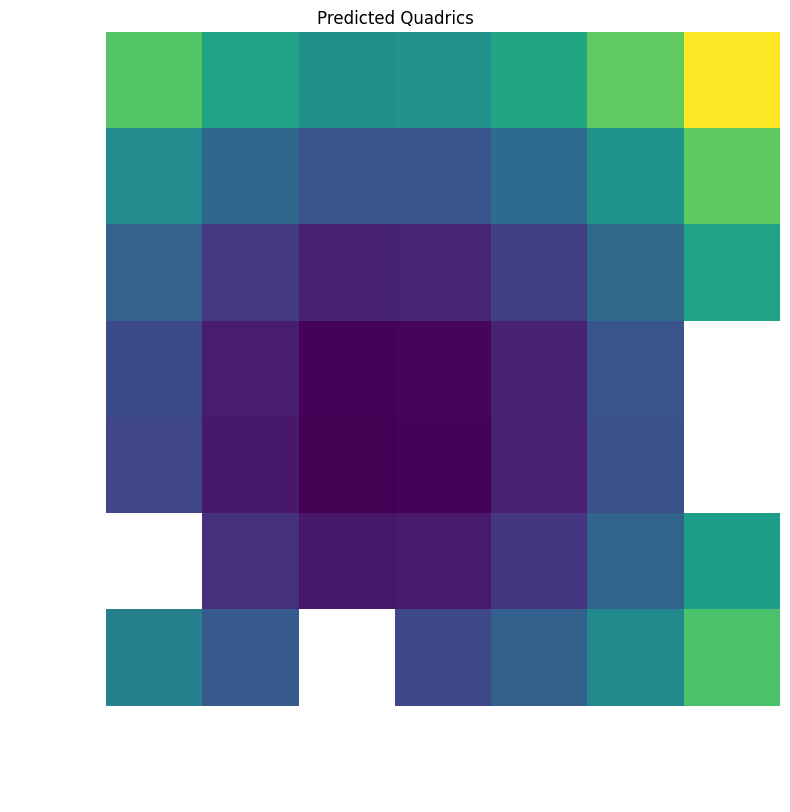

In [57]:
disp_util.display_figs([predicted_quadrics[ind]], titles=['Predicted Quadrics'])